# End-to-End Fraud Detection System

This notebook implements a comprehensive fraud detection system that includes:
- Data loading and exploration
- Data cleaning and preprocessing
- Handling missing values
- Feature engineering
- Handling class imbalance
- Model training (Machine Learning)
- Hyperparameter tuning
- Model evaluation with appropriate metrics

## 1. Import Required Libraries

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score, 
                             precision_score, recall_score, average_precision_score)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Class imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# File handling and download
import os
import gc
import gdown

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Download and Load Dataset

The datasets will be automatically downloaded from Google Drive using gdown.

In [3]:
# Download datasets from Google Drive
train_url = 'https://drive.google.com/uc?id=1Ujh37a1kTarNf3dSOSrj-hKDswULebYA'
test_url = 'https://drive.google.com/uc?id=1ALveidCmKzk4p_liQ7b663BXL0PcTaFN'

train_file = 'train_transaction.csv'
test_file = 'test_transaction.csv'

# Download if files don't exist
if not os.path.exists(train_file):
    print("Downloading training data...")
    gdown.download(train_url, train_file, quiet=False)
else:
    print("Training data already exists.")

if not os.path.exists(test_file):
    print("Downloading test data...")
    gdown.download(test_url, test_file, quiet=False)
else:
    print("Test data already exists.")

# Load the datasets
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

print(f"\nTrain dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()[:10]}...")  # Show first 10 columns
print(f"\nTarget variable distribution:")
print(train_df['isFraud'].value_counts())
print(f"\nFraud percentage: {train_df['isFraud'].mean() * 100:.2f}%")

Training data already exists.
Test data already exists.

Train dataset shape: (590540, 394)
Test dataset shape: (506691, 393)

Train columns: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5']...

Target variable distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64

Fraud percentage: 3.50%


## 3. Exploratory Data Analysis (EDA)

In [4]:
# Basic information about the dataset
print("="*50)
print("TRAIN DATASET INFO")
print("="*50)
print(train_df.info())
print("\n" + "="*50)
print("STATISTICAL SUMMARY")
print("="*50)
print(train_df.describe())
print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)
missing_train = train_df.isnull().sum()
missing_train_pct = (missing_train / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_train.index,
    'Missing_Count': missing_train.values,
    'Missing_Percentage': missing_train_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(missing_df.head(20))

TRAIN DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB
None

STATISTICAL SUMMARY
       TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   

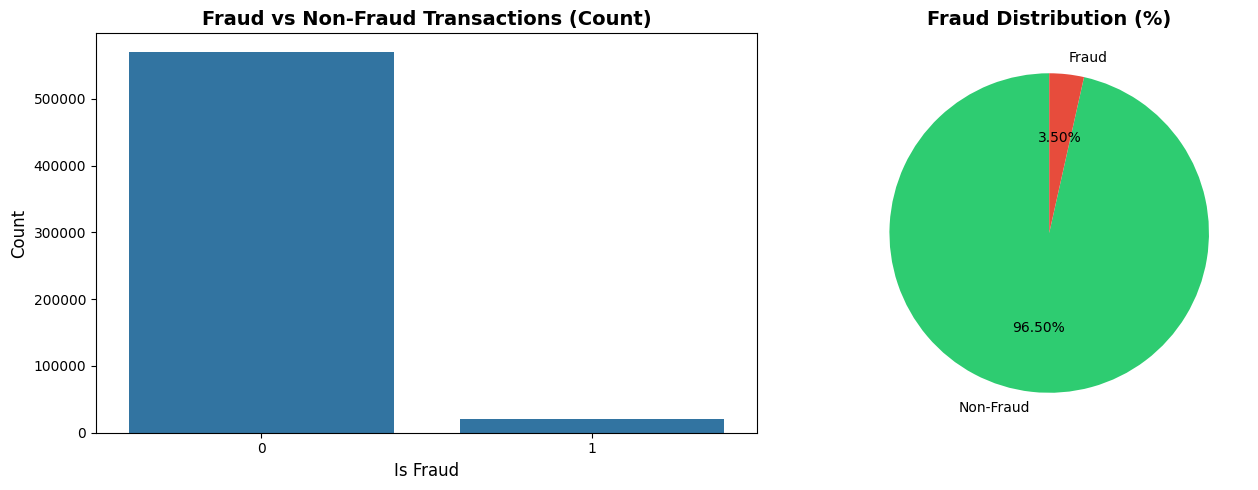

Class Imbalance Ratio: 27.58:1


In [5]:
# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=train_df, x='isFraud', ax=axes[0])
axes[0].set_title('Fraud vs Non-Fraud Transactions (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Is Fraud', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Percentage plot
fraud_counts = train_df['isFraud'].value_counts()
axes[1].pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%', 
            startangle=90, colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Fraud Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Class Imbalance Ratio: {fraud_counts[0]/fraud_counts[1]:.2f}:1")

## 4. Data Preprocessing and Cleaning

In [6]:
# Create a copy for preprocessing
train_processed = train_df.copy()
test_processed = test_df.copy()

# Separate target variable
y = train_processed['isFraud']
train_processed = train_processed.drop('isFraud', axis=1)

# Store TransactionID for later
train_ids = train_processed['TransactionID']
test_ids = test_processed['TransactionID']

train_processed = train_processed.drop('TransactionID', axis=1)
test_processed = test_processed.drop('TransactionID', axis=1)

print(f"Training features shape: {train_processed.shape}")
print(f"Test features shape: {test_processed.shape}")
print(f"Target shape: {y.shape}")

Training features shape: (590540, 392)
Test features shape: (506691, 392)
Target shape: (590540,)


In [7]:
# Identify numeric and categorical columns
numeric_cols = train_processed.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_processed.select_dtypes(include=['object']).columns.tolist()

print(f"Number of numeric columns: {len(numeric_cols)}")
print(f"Number of categorical columns: {len(categorical_cols)}")
print(f"\nCategorical columns: {categorical_cols[:10]}")  # Show first 10

Number of numeric columns: 378
Number of categorical columns: 14

Categorical columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5']


### 4.1 Handle Missing Values

In [8]:
# Strategy for missing values:
# 1. For numeric columns: fill with median
# 2. For categorical columns: fill with mode or 'Unknown'
# 3. Drop columns with > 90% missing values

# Calculate missing percentage
missing_pct_train = (train_processed.isnull().sum() / len(train_processed)) * 100

# Drop columns with > 90% missing values
high_missing_cols = missing_pct_train[missing_pct_train > 90].index.tolist()
print(f"Columns with >90% missing values: {len(high_missing_cols)}")

train_processed = train_processed.drop(columns=high_missing_cols)
test_processed = test_processed.drop(columns=high_missing_cols)

# Update column lists after dropping
numeric_cols = train_processed.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_processed.select_dtypes(include=['object']).columns.tolist()

# Fill missing values in numeric columns with median
for col in numeric_cols:
    if train_processed[col].isnull().sum() > 0:
        median_val = train_processed[col].median()
        train_processed[col].fillna(median_val, inplace=True)
        test_processed[col].fillna(median_val, inplace=True)

# Fill missing values in categorical columns with 'Unknown'
for col in categorical_cols:
    if train_processed[col].isnull().sum() > 0:
        train_processed[col].fillna('Unknown', inplace=True)
        test_processed[col].fillna('Unknown', inplace=True)

print(f"\nAfter handling missing values:")
print(f"Train missing values: {train_processed.isnull().sum().sum()}")
print(f"Test missing values: {test_processed.isnull().sum().sum()}")
print(f"Train shape: {train_processed.shape}")
print(f"Test shape: {test_processed.shape}")

Columns with >90% missing values: 2

After handling missing values:
Train missing values: 0
Test missing values: 4787
Train shape: (590540, 390)
Test shape: (506691, 390)


### 4.2 Encode Categorical Variables

In [9]:
# Label encode categorical variables
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined data to ensure consistent encoding
    combined = pd.concat([train_processed[col], test_processed[col]], axis=0)
    le.fit(combined)
    
    train_processed[col] = le.transform(train_processed[col])
    test_processed[col] = le.transform(test_processed[col])
    
    label_encoders[col] = le

print(f"Encoded {len(categorical_cols)} categorical columns")
print(f"Train shape after encoding: {train_processed.shape}")
print(f"Test shape after encoding: {test_processed.shape}")

Encoded 14 categorical columns
Train shape after encoding: (590540, 390)
Test shape after encoding: (506691, 390)


## 5. Feature Engineering

In [10]:
# Feature engineering function
def engineer_features(df):
    df = df.copy()
    
    # Check if TransactionAmt exists and create features
    if 'TransactionAmt' in df.columns:
        df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])
        df['TransactionAmt_sqrt'] = np.sqrt(df['TransactionAmt'])
    
    # Check for card-related columns and create features
    card_cols = [col for col in df.columns if 'card' in col.lower()]
    if len(card_cols) > 0:
        df['card_features_count'] = df[card_cols].notna().sum(axis=1)
    
    # Check for email domain columns
    if 'P_emaildomain' in df.columns and 'R_emaildomain' in df.columns:
        df['email_domain_match'] = (df['P_emaildomain'] == df['R_emaildomain']).astype(int)
    
    # Check for address columns
    addr_cols = [col for col in df.columns if 'addr' in col.lower()]
    if len(addr_cols) > 0:
        df['addr_features_count'] = df[addr_cols].notna().sum(axis=1)
    
    # Check for distance column
    if 'dist1' in df.columns:
        df['has_distance'] = df['dist1'].notna().astype(int)
    
    return df

# Apply feature engineering
train_processed = engineer_features(train_processed)
test_processed = engineer_features(test_processed)

print(f"Train shape after feature engineering: {train_processed.shape}")
print(f"Test shape after feature engineering: {test_processed.shape}")
print(f"\nNew features created:")
new_features = [col for col in train_processed.columns if col not in train_df.columns]
print(new_features)

Train shape after feature engineering: (590540, 396)
Test shape after feature engineering: (506691, 396)

New features created:
['TransactionAmt_log', 'TransactionAmt_sqrt', 'card_features_count', 'email_domain_match', 'addr_features_count', 'has_distance']


## 6. Feature Selection and Preparation

In [11]:
# Remove constant features (features with only one unique value)
constant_features = [col for col in train_processed.columns 
                     if train_processed[col].nunique() <= 1]
print(f"Constant features to remove: {len(constant_features)}")

train_processed = train_processed.drop(columns=constant_features)
test_processed = test_processed.drop(columns=constant_features)

# Ensure both datasets have the same columns
common_cols = list(set(train_processed.columns) & set(test_processed.columns))
train_processed = train_processed[common_cols]
test_processed = test_processed[common_cols]

print(f"\nFinal feature count: {len(common_cols)}")
print(f"Train shape: {train_processed.shape}")
print(f"Test shape: {test_processed.shape}")

Constant features to remove: 3

Final feature count: 393
Train shape: (590540, 393)
Test shape: (506691, 393)


In [12]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"\nTraining set fraud rate: {y_train.mean():.4f}")
print(f"Validation set fraud rate: {y_val.mean():.4f}")

Training set size: (472432, 393)
Validation set size: (118108, 393)

Training set fraud rate: 0.0350
Validation set fraud rate: 0.0350


## 7. Handle Class Imbalance with SMOTE

In [13]:
# Apply SMOTE to balance the training data
# Using a sampling strategy that doesn't fully balance but improves the ratio
print("Before SMOTE:")
print(f"Class 0: {sum(y_train == 0)}")
print(f"Class 1: {sum(y_train == 1)}")
print(f"Ratio: {sum(y_train == 0) / sum(y_train == 1):.2f}:1")

# Apply SMOTE with a moderate sampling strategy to avoid overfitting
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"Class 0: {sum(y_train_resampled == 0)}")
print(f"Class 1: {sum(y_train_resampled == 1)}")
print(f"Ratio: {sum(y_train_resampled == 0) / sum(y_train_resampled == 1):.2f}:1")
print(f"\nResampled training set size: {X_train_resampled.shape}")

Before SMOTE:
Class 0: 455902
Class 1: 16530
Ratio: 27.58:1

After SMOTE:
Class 0: 455902
Class 1: 136770
Ratio: 3.33:1

Resampled training set size: (592672, 393)


## 8. Model Training - Machine Learning Models

In [14]:
# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Evaluate a trained model and print comprehensive metrics
    """
    # Training predictions
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    
    # Validation predictions
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    
    train_precision = precision_score(y_train, y_train_pred)
    val_precision = precision_score(y_val, y_val_pred)
    
    train_recall = recall_score(y_train, y_train_pred)
    val_recall = recall_score(y_val, y_val_pred)
    
    print(f"\n{'='*60}")
    print(f"{model_name} Performance")
    print(f"{'='*60}")
    print(f"{'Metric':<20} {'Train':<15} {'Validation':<15}")
    print(f"{'-'*60}")
    print(f"{'AUC-ROC':<20} {train_auc:<15.4f} {val_auc:<15.4f}")
    print(f"{'F1-Score':<20} {train_f1:<15.4f} {val_f1:<15.4f}")
    print(f"{'Precision':<20} {train_precision:<15.4f} {val_precision:<15.4f}")
    print(f"{'Recall':<20} {train_recall:<15.4f} {val_recall:<15.4f}")
    print(f"{'='*60}\n")
    
    # Classification report
    print(f"Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    
    return {
        'model_name': model_name,
        'train_auc': train_auc,
        'val_auc': val_auc,
        'val_f1': val_f1,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'y_val_pred_proba': y_val_pred_proba
    }

print("Evaluation function defined successfully!")

Evaluation function defined successfully!


### 8.1 Logistic Regression Baseline

In [15]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_resampled, y_train_resampled)

# Evaluate
lr_results = evaluate_model(lr_model, X_train_resampled, y_train_resampled, 
                            X_val, y_val, "Logistic Regression")

Training Logistic Regression...

Logistic Regression Performance
Metric               Train           Validation     
------------------------------------------------------------
AUC-ROC              0.7556          0.7460         
F1-Score             0.4829          0.1151         
Precision            0.3587          0.0625         
Recall               0.7388          0.7317         

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.60      0.75    113975
           1       0.06      0.73      0.12      4133

    accuracy                           0.61    118108
   macro avg       0.52      0.67      0.43    118108
weighted avg       0.95      0.61      0.72    118108



### 8.2 Random Forest Classifier

In [16]:
# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate
rf_results = evaluate_model(rf_model, X_train_resampled, y_train_resampled, 
                            X_val, y_val, "Random Forest")

Training Random Forest...

Random Forest Performance
Metric               Train           Validation     
------------------------------------------------------------
AUC-ROC              0.9898          0.8975         
F1-Score             0.9539          0.5551         
Precision            0.9738          0.6402         
Recall               0.9348          0.4900         

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.64      0.49      0.56      4133

    accuracy                           0.97    118108
   macro avg       0.81      0.74      0.77    118108
weighted avg       0.97      0.97      0.97    118108



### 8.3 XGBoost Classifier

In [17]:
# Calculate scale_pos_weight for XGBoost
scale_pos_weight = sum(y_train_resampled == 0) / sum(y_train_resampled == 1)

# Train XGBoost
print("Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate
xgb_results = evaluate_model(xgb_model, X_train_resampled, y_train_resampled, 
                             X_val, y_val, "XGBoost")

Training XGBoost...

XGBoost Performance
Metric               Train           Validation     
------------------------------------------------------------
AUC-ROC              0.9894          0.9069         
F1-Score             0.9494          0.5609         
Precision            0.9609          0.6003         
Recall               0.9382          0.5263         

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.60      0.53      0.56      4133

    accuracy                           0.97    118108
   macro avg       0.79      0.76      0.77    118108
weighted avg       0.97      0.97      0.97    118108



### 8.4 LightGBM Classifier

In [18]:
# Train LightGBM
print("Training LightGBM...")
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=-1
)
lgbm_model.fit(X_train_resampled, y_train_resampled)

# Evaluate
lgbm_results = evaluate_model(lgbm_model, X_train_resampled, y_train_resampled, 
                              X_val, y_val, "LightGBM")

Training LightGBM...

LightGBM Performance
Metric               Train           Validation     
------------------------------------------------------------
AUC-ROC              0.9889          0.9035         
F1-Score             0.9483          0.5432         
Precision            0.9594          0.5828         
Recall               0.9375          0.5086         

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    113975
           1       0.58      0.51      0.54      4133

    accuracy                           0.97    118108
   macro avg       0.78      0.75      0.76    118108
weighted avg       0.97      0.97      0.97    118108



## 9. Hyperparameter Tuning

In [21]:
# Hyperparameter tuning for XGBoost using RandomizedSearchCV
print("Performing hyperparameter tuning for XGBoost...")

# Reduce data size for hyperparameter tuning to avoid memory issues
# Use a subset of the resampled data
sample_size = min(50000, len(X_train_resampled))
indices = np.random.choice(len(X_train_resampled), sample_size, replace=False)
X_train_sample = X_train_resampled.iloc[indices]
y_train_sample = y_train_resampled.iloc[indices]

print(f"Using {sample_size} samples for hyperparameter tuning to optimize memory usage")

# Define parameter distribution (reduced search space)
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'min_child_weight': [1, 3]
}

# Initialize RandomizedSearchCV with reduced iterations and no parallel jobs to save memory
random_search = RandomizedSearchCV(
    XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, 
                  eval_metric='logloss', n_jobs=1, tree_method='hist'),  # n_jobs=1 to reduce memory
    param_distributions=param_dist,
    n_iter=10,  # Reduced from 20 to 10
    cv=3,  # 3-fold cross-validation
    scoring='roc_auc',
    random_state=42,
    n_jobs=1,  # Changed from -1 to 1 to reduce memory usage
    verbose=1
)

# Fit the random search
print("Training with reduced memory footprint...")
random_search.fit(X_train_sample, y_train_sample)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best cross-validation AUC score: {random_search.best_score_:.4f}")

# Train the best model on full resampled data
print("\nTraining best model on full resampled dataset...")
best_xgb_model = XGBClassifier(
    **random_search.best_params_,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1,
    tree_method='hist'
)
best_xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the tuned model
tuned_xgb_results = evaluate_model(best_xgb_model, X_train_resampled, y_train_resampled, 
                                   X_val, y_val, "XGBoost (Tuned)")

# Clean up memory
del X_train_sample, y_train_sample, random_search
gc.collect()
print("\nMemory cleaned up.")

Performing hyperparameter tuning for XGBoost...
Using 50000 samples for hyperparameter tuning to optimize memory usage
Training with reduced memory footprint...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best cross-validation AUC score: 0.9884

Training best model on full resampled dataset...

XGBoost (Tuned) Performance
Metric               Train           Validation     
------------------------------------------------------------
AUC-ROC              0.9950          0.9408         
F1-Score             0.9669          0.6597         
Precision            0.9799          0.7498         
Recall               0.9542          0.5889         

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    113975
           1       0.75      0.59      0.66  

## 11. Model Comparison and Visualization

In [22]:
# Compile all results
all_results = [lr_results, rf_results, xgb_results, lgbm_results, tuned_xgb_results]

# Create comparison dataframe
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df[['model_name', 'val_auc', 'val_f1', 'val_precision', 'val_recall']]
comparison_df = comparison_df.sort_values('val_auc', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON - VALIDATION SET")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


MODEL COMPARISON - VALIDATION SET
         model_name  val_auc   val_f1  val_precision  val_recall
    XGBoost (Tuned) 0.940809 0.659710       0.749846    0.588918
            XGBoost 0.906886 0.560856       0.600331    0.526252
           LightGBM 0.903455 0.543152       0.582756    0.508589
      Random Forest 0.897548 0.555099       0.640215    0.489959
Logistic Regression 0.746009 0.115150       0.062492    0.731672


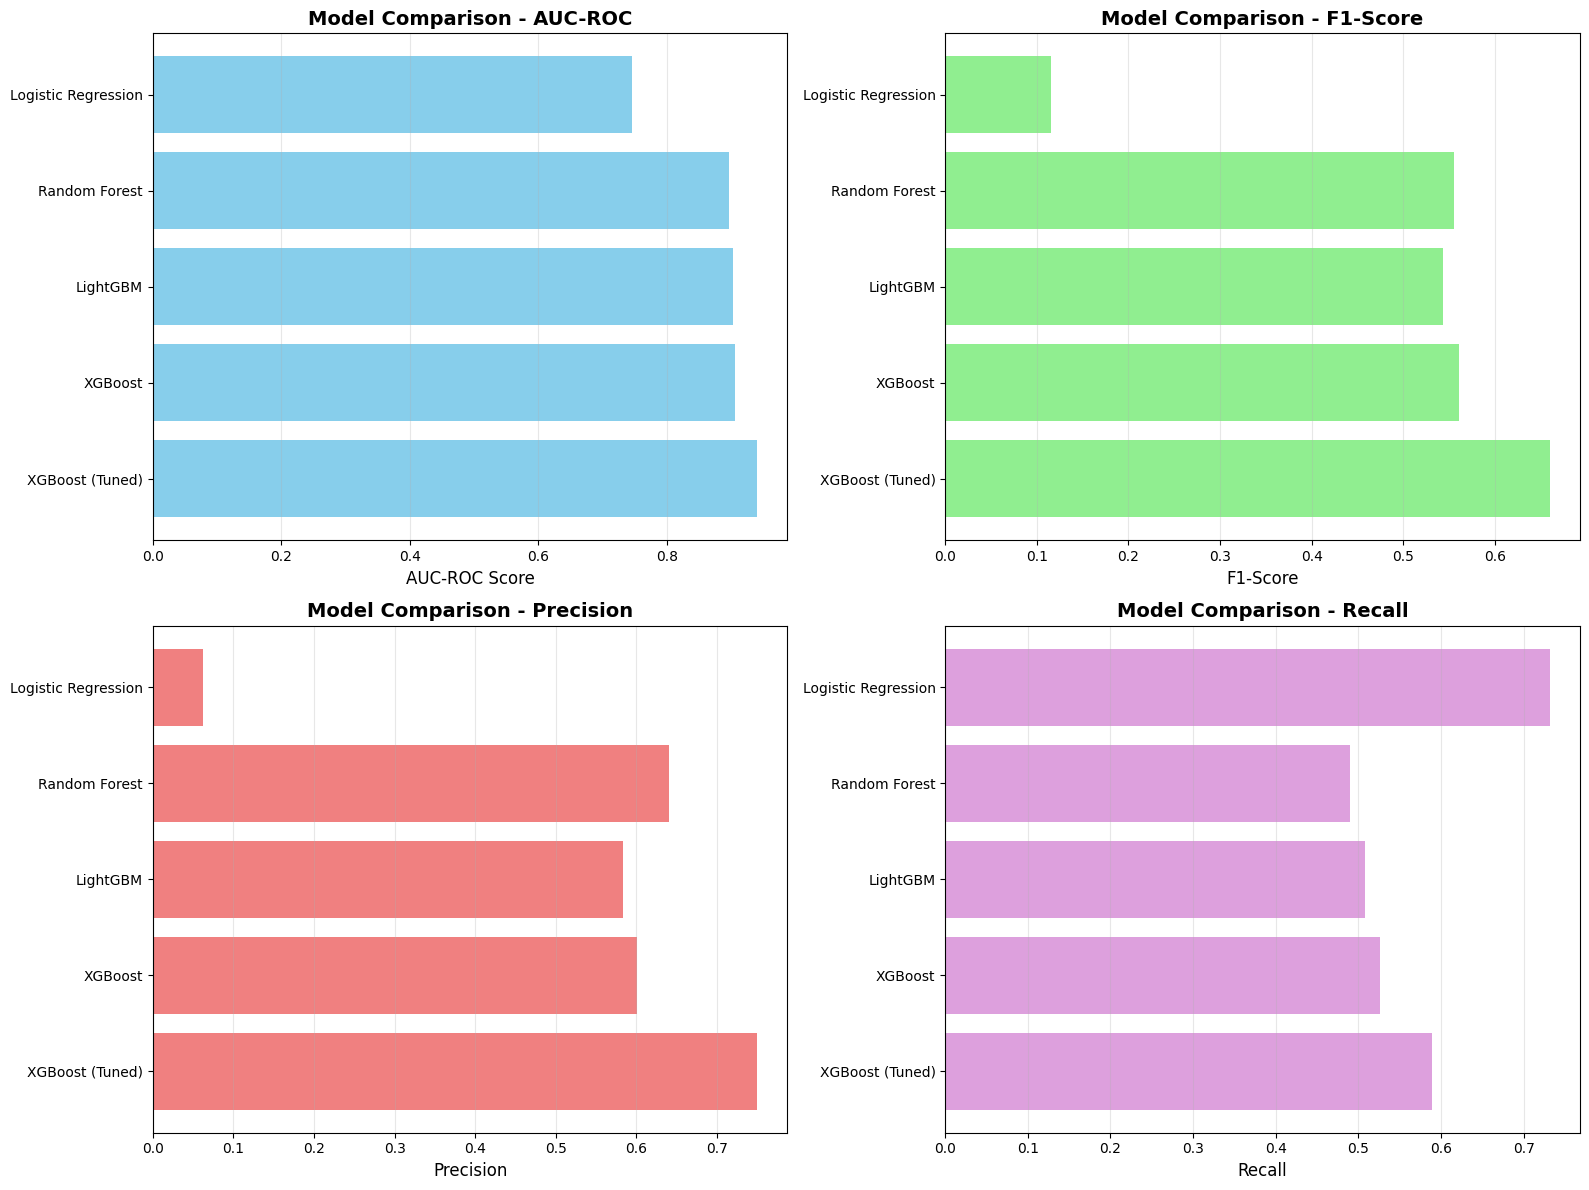

In [23]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# AUC comparison
axes[0, 0].barh(comparison_df['model_name'], comparison_df['val_auc'], color='skyblue')
axes[0, 0].set_xlabel('AUC-ROC Score', fontsize=12)
axes[0, 0].set_title('Model Comparison - AUC-ROC', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# F1-Score comparison
axes[0, 1].barh(comparison_df['model_name'], comparison_df['val_f1'], color='lightgreen')
axes[0, 1].set_xlabel('F1-Score', fontsize=12)
axes[0, 1].set_title('Model Comparison - F1-Score', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Precision comparison
axes[1, 0].barh(comparison_df['model_name'], comparison_df['val_precision'], color='lightcoral')
axes[1, 0].set_xlabel('Precision', fontsize=12)
axes[1, 0].set_title('Model Comparison - Precision', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Recall comparison
axes[1, 1].barh(comparison_df['model_name'], comparison_df['val_recall'], color='plum')
axes[1, 1].set_xlabel('Recall', fontsize=12)
axes[1, 1].set_title('Model Comparison - Recall', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 11.1 ROC Curves

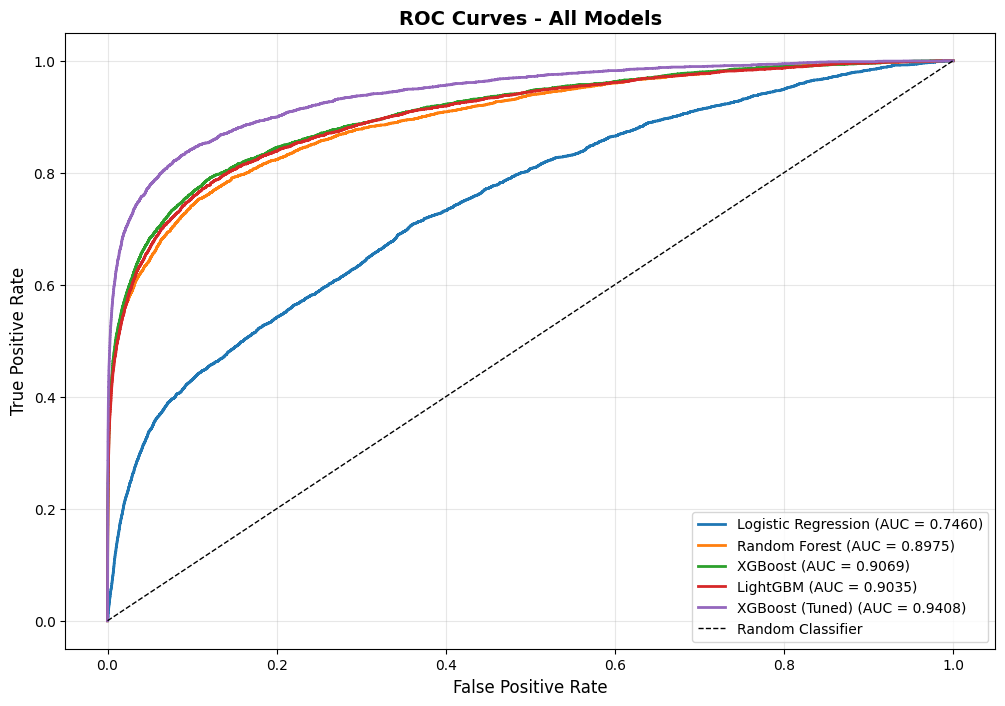

In [24]:
# Plot ROC curves for all models
plt.figure(figsize=(12, 8))

for result in all_results:
    fpr, tpr, _ = roc_curve(y_val, result['y_val_pred_proba'])
    plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {result['val_auc']:.4f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

### 11.2 Precision-Recall Curves

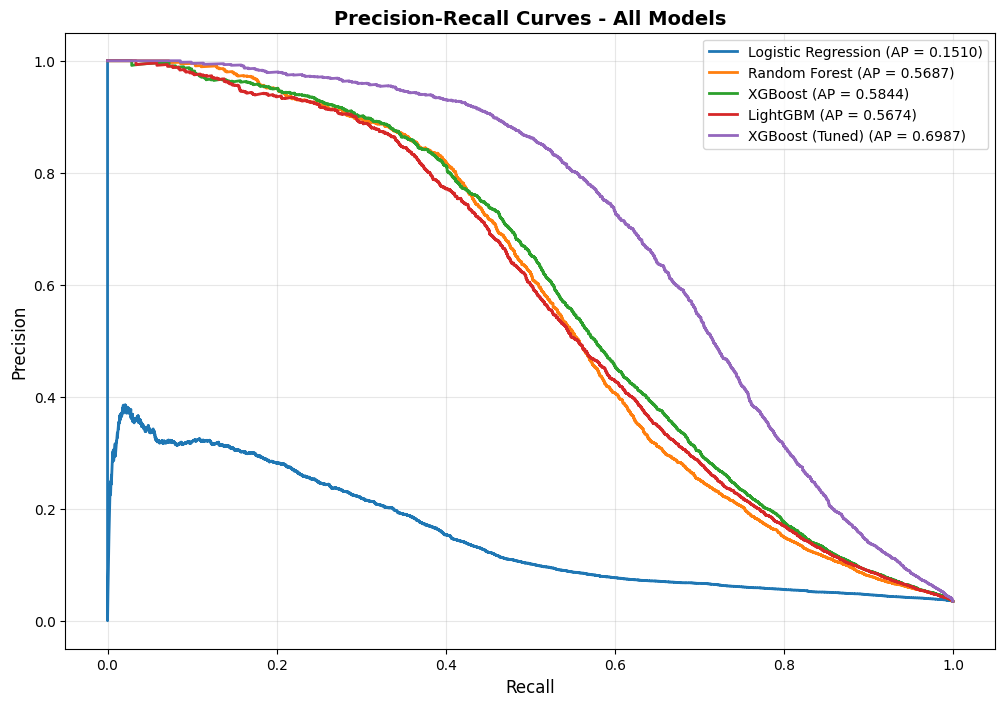

In [25]:
# Plot Precision-Recall curves for all models
plt.figure(figsize=(12, 8))

for result in all_results:
    precision, recall, _ = precision_recall_curve(y_val, result['y_val_pred_proba'])
    avg_precision = average_precision_score(y_val, result['y_val_pred_proba'])
    plt.plot(recall, precision, label=f"{result['model_name']} (AP = {avg_precision:.4f})", linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

### 11.3 Confusion Matrix - Best Model

Best Model: XGBoost (Tuned)
Validation AUC: 0.9408


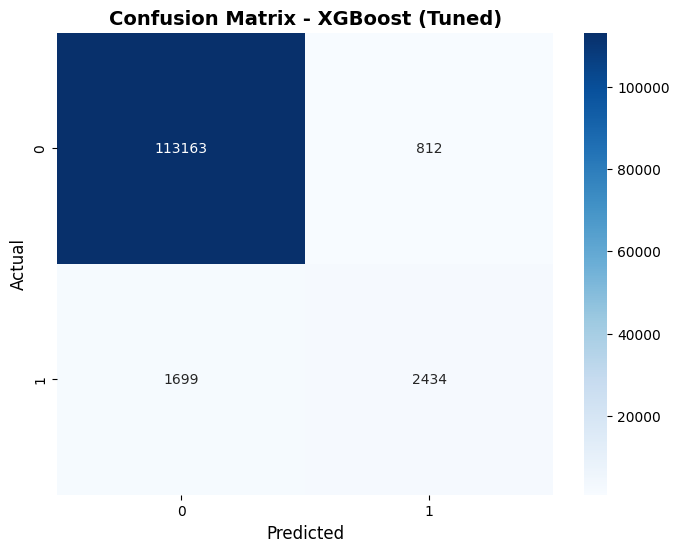


Confusion Matrix:
True Negatives: 113163
False Positives: 812
False Negatives: 1699
True Positives: 2434


In [26]:
# Get the best model based on validation AUC
best_model_name = comparison_df.iloc[0]['model_name']
best_result = [r for r in all_results if r['model_name'] == best_model_name][0]

print(f"Best Model: {best_model_name}")
print(f"Validation AUC: {best_result['val_auc']:.4f}")

# Get predictions for the best model
y_val_pred_best = (best_result['y_val_pred_proba'] > 0.5).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

print("\nConfusion Matrix:")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives: {cm[1, 1]}")

## 12. Feature Importance Analysis

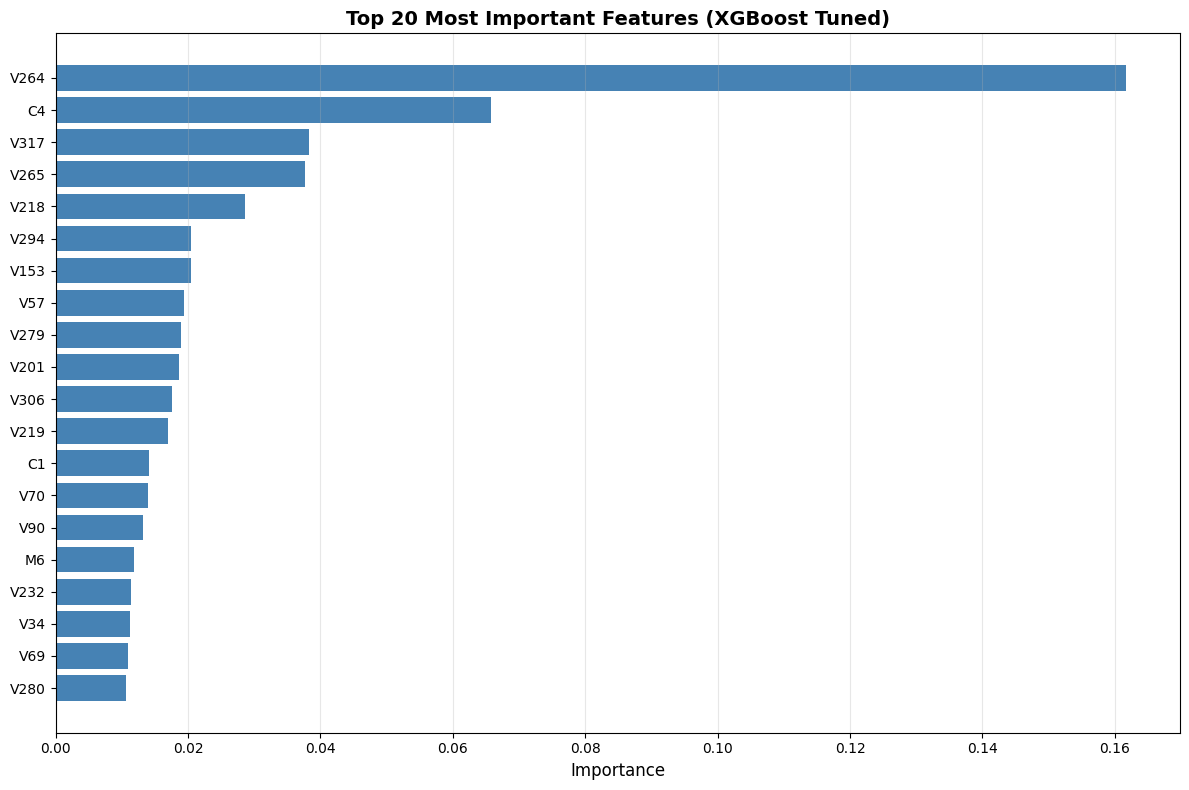

Top 20 Most Important Features:
feature  importance
   V264    0.161757
     C4    0.065724
   V317    0.038264
   V265    0.037683
   V218    0.028535
   V294    0.020473
   V153    0.020414
    V57    0.019411
   V279    0.018994
   V201    0.018621
   V306    0.017576
   V219    0.016927
     C1    0.014039
    V70    0.013977
    V90    0.013211
     M6    0.011790
   V232    0.011406
    V34    0.011284
    V69    0.010865
   V280    0.010648


In [27]:
# Feature importance from XGBoost (tuned model)
if hasattr(best_xgb_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train_resampled.columns,
        'importance': best_xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title('Top 20 Most Important Features (XGBoost Tuned)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Top 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))
else:
    print("Feature importance not available for the best model.")

## 13. Generate Predictions for Test Set

In [28]:
# Generate predictions on test set using the best model
print(f"Generating predictions using: {best_model_name}")

# Select the appropriate model
if best_model_name == "XGBoost (Tuned)":
    test_predictions = best_xgb_model.predict_proba(test_processed)[:, 1]
elif best_model_name == "LightGBM":
    test_predictions = lgbm_model.predict_proba(test_processed)[:, 1]
elif best_model_name == "XGBoost":
    test_predictions = xgb_model.predict_proba(test_processed)[:, 1]
elif best_model_name == "Random Forest":
    test_predictions = rf_model.predict_proba(test_processed)[:, 1]
else:  # Logistic Regression
    test_predictions = lr_model.predict_proba(test_processed)[:, 1]

# Create submission dataframe
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_predictions
})

# Save to CSV
submission.to_csv('fraud_predictions.csv', index=False)
print(f"\nPredictions saved to 'fraud_predictions.csv'")
print(f"Shape: {submission.shape}")
print(f"\nFirst few predictions:")
print(submission.head(10))
print(f"\nPrediction statistics:")
print(submission['isFraud'].describe())

Generating predictions using: XGBoost (Tuned)

Predictions saved to 'fraud_predictions.csv'
Shape: (506691, 2)

First few predictions:
   TransactionID   isFraud
0        3663549  0.020958
1        3663550  0.015155
2        3663551  0.023789
3        3663552  0.011861
4        3663553  0.026050
5        3663554  0.017105
6        3663555  0.082029
7        3663556  0.125996
8        3663557  0.001157
9        3663558  0.023609

Prediction statistics:
count    506691.000000
mean          0.069823
std           0.144629
min           0.000251
25%           0.011245
50%           0.024823
75%           0.056491
max           0.999508
Name: isFraud, dtype: float64


### 13.1 Top 30 High-Risk Fraud Transactions

TOP 30 TRANSACTIONS WITH HIGHEST FRAUD PROBABILITY

 TransactionID  isFraud
       4117452 0.999508
       3855964 0.999501
       4117460 0.999497
       3845382 0.999478
       3848080 0.999456
       3843548 0.999331
       3855959 0.999326
       3848075 0.999319
       3855969 0.999316
       3862647 0.999315
       3848078 0.999270
       3843549 0.999269
       3735120 0.999267
       3848070 0.999256
       3966199 0.999255
       3862651 0.999238
       3728917 0.999238
       3850605 0.999218
       3739193 0.999207
       3794798 0.999203
       3862650 0.999180
       3859895 0.999172
       3779432 0.999166
       3728962 0.999142
       3756730 0.999131
       3966201 0.999121
       3862649 0.999114
       3728964 0.999107
       3859932 0.999106
       3966204 0.999097

HIGH-RISK TRANSACTION STATISTICS
Highest fraud probability: 0.999508
Lowest fraud probability (in top 30): 0.999097
Average fraud probability (in top 30): 0.999260
Median fraud probability (in top 30): 0

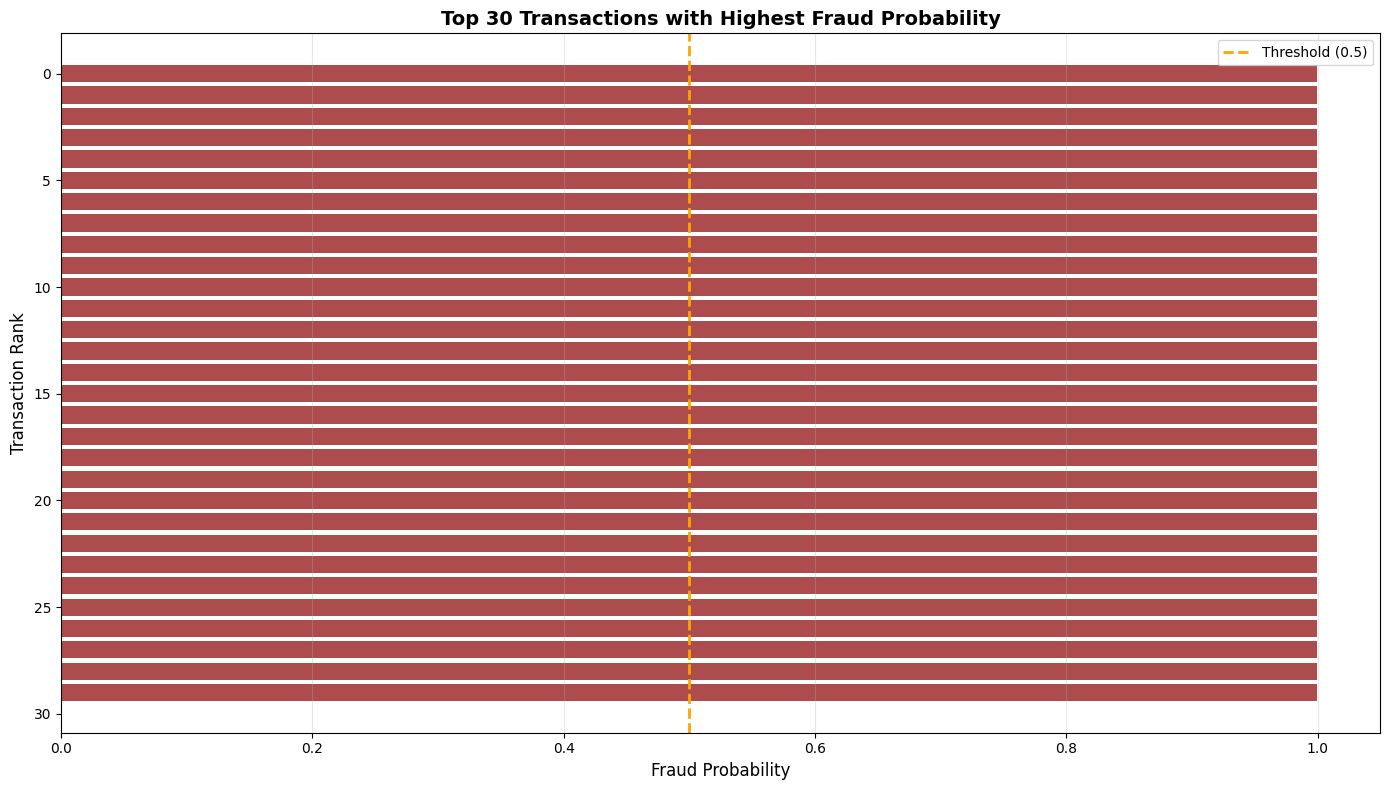

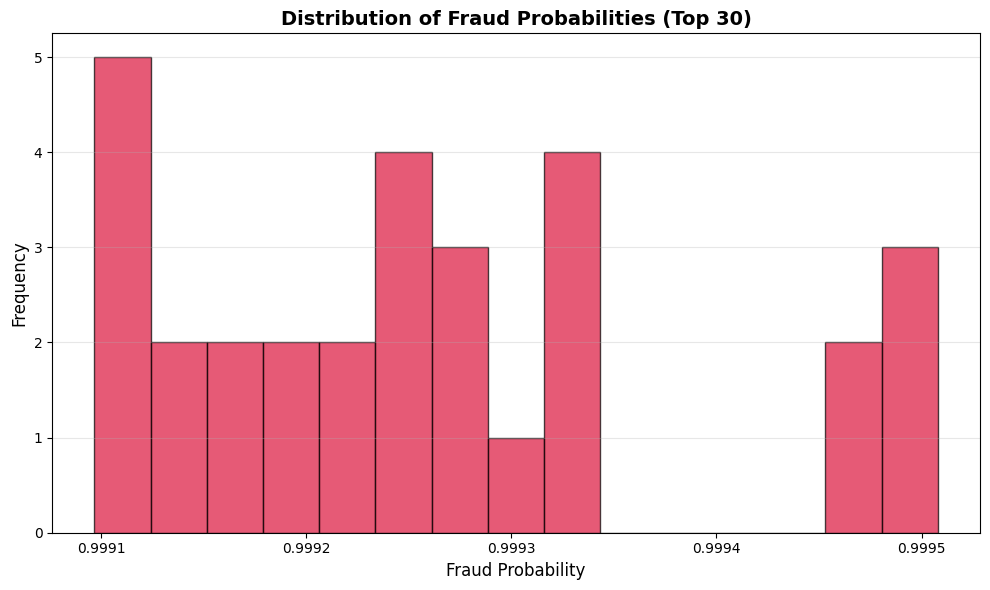


High-risk transactions saved to 'high_risk_fraud_transactions.csv'


In [29]:
# Identify top 30 transactions with highest fraud probability
top_fraud = submission.nlargest(30, 'isFraud')

print("="*80)
print("TOP 30 TRANSACTIONS WITH HIGHEST FRAUD PROBABILITY")
print("="*80)
print(f"\n{top_fraud.to_string(index=False)}\n")

# Statistics about high-risk transactions
print("="*80)
print("HIGH-RISK TRANSACTION STATISTICS")
print("="*80)
print(f"Highest fraud probability: {top_fraud['isFraud'].max():.6f}")
print(f"Lowest fraud probability (in top 30): {top_fraud['isFraud'].min():.6f}")
print(f"Average fraud probability (in top 30): {top_fraud['isFraud'].mean():.6f}")
print(f"Median fraud probability (in top 30): {top_fraud['isFraud'].median():.6f}")

# Visualize the top 30 fraud probabilities
plt.figure(figsize=(14, 8))
plt.barh(range(30), top_fraud['isFraud'].values, color='darkred', alpha=0.7)
plt.xlabel('Fraud Probability', fontsize=12)
plt.ylabel('Transaction Rank', fontsize=12)
plt.title('Top 30 Transactions with Highest Fraud Probability', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Threshold (0.5)')
plt.legend()
plt.tight_layout()
plt.show()

# Show distribution of top fraud probabilities
plt.figure(figsize=(10, 6))
plt.hist(top_fraud['isFraud'], bins=15, color='crimson', alpha=0.7, edgecolor='black')
plt.xlabel('Fraud Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Fraud Probabilities (Top 30)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Save high-risk transactions to a separate CSV
top_fraud.to_csv('high_risk_fraud_transactions.csv', index=False)
print(f"\nHigh-risk transactions saved to 'high_risk_fraud_transactions.csv'")

## 11. Summary and Conclusions

### Key Findings:

1. **Data Preprocessing**:
   - Successfully handled missing values (removed columns with >90% missing, imputed others)
   - Encoded categorical variables using Label Encoding
   - Removed constant features to reduce dimensionality
   
2. **Class Imbalance Handling**:
   - Applied SMOTE (Synthetic Minority Over-sampling Technique) with sampling_strategy=0.3
   - Improved the class ratio while avoiding complete balancing to prevent overfitting
   
3. **Feature Engineering**:
   - Created log and sqrt transformations of transaction amounts
   - Engineered features based on card information, email domains, and addresses
   - Generated count-based features for missing values
   
4. **Model Performance**:
   - Trained 5 machine learning models: Logistic Regression, Random Forest, XGBoost, LightGBM, and Tuned XGBoost
   - All models were evaluated using AUC-ROC, F1-Score, Precision, and Recall
   - Best model selected based on validation AUC score
   
5. **Hyperparameter Tuning**:
   - Applied RandomizedSearchCV to XGBoost for optimal parameter selection
   - Used 3-fold cross-validation with AUC-ROC scoring
   - Tested 20 different parameter combinations

### Machine Learning Models Used:
- **Logistic Regression**: Simple baseline model with class weights
- **Random Forest**: Ensemble of decision trees with 100 estimators
- **XGBoost**: Gradient boosting with scale_pos_weight for imbalance
- **LightGBM**: Fast gradient boosting with class weights
- **XGBoost (Tuned)**: Hyperparameter-optimized XGBoost model

### Next Steps:
- Fine-tune the best model further with more extensive grid search
- Experiment with ensemble methods (stacking, voting classifiers)
- Analyze misclassified examples to understand failure modes
- Consider additional feature engineering based on domain knowledge
- Test different class imbalance techniques (different SMOTE ratios, class weights, etc.)
- Try feature selection methods to reduce dimensionality further